# Homework 5

Michael Roper

The following Python code executes a Sequential Quadratic Program (SQP).

/var/folders/0f/4_g_jz45603_08pl2n81x0400000gn/T/ipykernel_7916/969219137.py:151: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(v[0], 2*v[0]**0.5, 'k')
/var/folders/0f/4_g_jz45603_08pl2n81x0400000gn/T/ipykernel_7916/969219137.py:152: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(v[0], (15 - 5*v[0])**0.5 + 1, 'k')


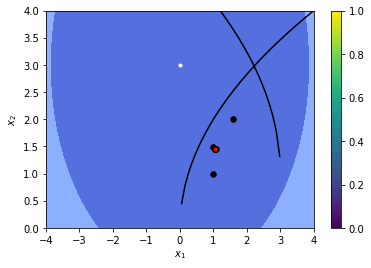

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm


# Define objective function; argument must be NumPy ndarray (2, 1)
def obfun(x):
    return x[0]**2 + (x[1] - 3)**2


# Define gradient of objective function; argument must be NumPy ndarray (2, 1)
def obfung(x):
    return np.array([2*x[0], 2*(x[1] - 3)])


# Define constraints; argument must be NumPy ndarray (2, 1)
def confun(x):
    return np.array([x[1]**2 - 2*x[0], (x[1] - 1)**2 + 5*x[0] - 15])


# Define gradient of constraints; argument must be NumPy ndarray (2, 1)
def confung(x):
    return np.array([[-2, 2*x[1]], [5, 2*(x[1] - 1)]])


# Define Lagrangian
def lagrange(x, mu):
    return obfun(x) + mu.T @ confun(x)


# Define gradient of Lagrangian
def lagrangeg(x, mu):
    return obfung(x) + mu @ confung(x)


# Define norm
def norm(z):
    return z @ z


# Define active set strategy
def activeset(x, W, c, A, b):

    AA = A.reshape([-1, 2])

    if np.size(A) == 0:
        M = W
        U = -c
    else:
        M = np.block([[W, AA.T], [AA, np.zeros([np.size(AA, 0), np.size(AA, 0)])]])
        U = np.block([-c, b])

    sol = np.linalg.inv(M) @ U

    return sol


#Define QP solver
def qpsolver(x, W):

    A0 = confung(x)
    b0 = -confun(x)

    active = []
    stop = 0

    while not stop:
        mu0 = np.zeros(2)
        if len(active) == 0:
            A = A0[active, :]
            b = b0[active]
        else:
            A = A0[int(active[0])]
            b = b0[int(active[0])]

        sol = activeset(x, W, obfung(x), A, b)
        s = sol[:2]
        mu = sol[2:]
        mu = np.round(mu*1e12)/1e12

        if len(active) == 0:
            mu0 = []
        else:
            for i in range(len(active)):
                mu0[int(active[i])] = mu[i]

        gcheck = A0 @ s - b0
        gcheck = np.round(gcheck*1e12)/1e12

        mucheck = 0

        ladd = []
        lremove = []

        if len(mu) == 0:
            mucheck = 1
        elif min(mu) > 0:
            mucheck = 1
        else:
            lremove = np.argmin(mu)

        if max(gcheck) <= 0:
            if mucheck == 1:
                stop = 1
        else:
            ladd = np.argmax(gcheck)

        active = np.setdiff1d(active, lremove)
        active = np.append(active, ladd)
        active = np.unique(active)

    return s, mu0

# Define line search
def linesearch(x, s, mu, w):
    t, b, a = 0.1, 0.8, 1.
    for i in range(len(mu)):
        w[i] = max(abs(mu[i]), 0.5*(w[i] + abs(mu[i])))

    count = 0
    d = (confun(x) > 0) + 0.
    phi0 = obfun(x) + w[0] * abs(min(0., -confun(x)[0])) + w[1] * abs(min(0., -confun(x)[1]))
    dphi0 = obfung(x) @ s + (w*d) @ confung(x) @ s
    while count < 10:
        phi = obfun(x + a*s) + w[0]*abs(min(0., -confun(x + a*s)[0])) + w[1]*abs(min(0., -confun(x + a*s)[1]))
        f = phi0 + t*a*dphi0
        if phi > f:
            a = b * a
            count += 1
        else:
            return a, w


# Define BFGS
def bfgs(W, x, dx, mu):

    y = lagrangeg(x, mu) - lagrangeg(x-dx, mu)

    W = W + np.outer(y, y)/(y @ dx) - (W @ np.outer(dx, dx) @ W)/(dx @ W @ dx)

    return W


# Define reporting function
def report(sol_hist_x1, sol_hist_x2):
    v = [np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)]
    v_grid = np.meshgrid(v[0], v[1])
    f = obfun(v_grid)
    plt.contourf(v[0], v[1], f, cmap=cm.coolwarm)
    plt.plot(v[0], 2*v[0]**0.5, 'k')
    plt.plot(v[0], (15 - 5*v[0])**0.5 + 1, 'k')
    plt.plot(0, 3, 'wo', markersize=3)
    plt.scatter(sol_hist_x1, sol_hist_x2, linewidths=0.5, marker='o', c='k')
    plt.plot(sol_hist_x1[-1], sol_hist_x2[-1], 'ro', markersize=3)
    plt.colorbar()
    plt.xlim([-4, 4])
    plt.ylim([-0, 4])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()


# Initialize values.
n = 2  # No. of variables
m = 2  # No. of constraints

x = np.array([1., 1.])  # Initialize x
mu = np.array([0., 0.])  # Initialize Lagrange multipliers
W = np.eye(n)  # Initialize Hessian
eps = 1e-24  # Initialize termination criteria
w = np.array([1., 1.])  # Initialize weights of merit function

# Check feasibility of initial guess
if max(confun(x)) > 0:
    print("Infeasible initial guess!")
    quit()

# Compute gradient of Lagrangian.
dL = lagrangeg(x, mu)

# Initialize storage arrays for solution at each iteration.
sol_hist_x1 = [x[0]]
sol_hist_x2 = [x[1]]

while norm(dL) > eps:

    # Compute search direction and Lagrange multiplier(s)
    s, mu = qpsolver(x, W)

    # Compute step size in search direction
    a, w = linesearch(x, s, mu, w)

    # Compute next solution
    x += a*s

    # Store solution at each iteration
    sol_hist_x1.append(x[0])
    sol_hist_x2.append(x[1])

    # Approximate Hessian of Lagrangian using BFGS
    W = bfgs(W, x, a*s, mu)

    # Calculate gradient of Lagrangian
    dL = lagrangeg(x, mu)

report(sol_hist_x1, sol_hist_x2)

The solution is represented by the red point in the plot above. The feasible space is the region between the two black curves below their intersection. The black points show the solution at each iteration of the program. The white point represents the global minimum of the objective function.

I am not sure why the program stops at this solution when visually it can be observed that there is a better solution in the feasible domain. As you can see, the norm of the gradient of the Lagrangian is virtually zero at this solution.

In [2]:
print(x)
print(norm(dL))

[1.06020716 1.45616425]
8.725813325855337e-25
